In [121]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [122]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [123]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs are available: {gpus}")
else:
    print("No GPU found.")

GPUs are available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [124]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [125]:
# !unzip data.zip
# data taken from jupyter notebook code.

In [126]:
# Take 300 images from each
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [127]:
POS_PATH

'data/positive'

In [128]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [129]:
dir_test = anchor.as_numpy_iterator()

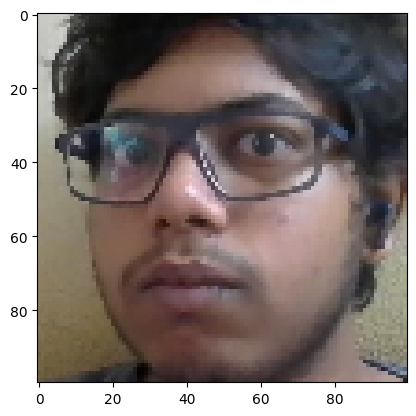

In [130]:
plt.imshow(preprocess(dir_test.next()))

In [131]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [132]:
samples = data.as_numpy_iterator()

In [133]:
example = samples.next()

In [134]:
example

(b'data/anchor/13785414-7d70-11ef-8c55-e40d3697e9b4.jpg',
 b'data/positive/2fe8af60-7d70-11ef-be4c-e40d3697e9b4.jpg',
 1.0)

In [135]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)
# can be done with preprocess on anchor, positive and negative seperately also

In [136]:
res = preprocess_twin(*example)

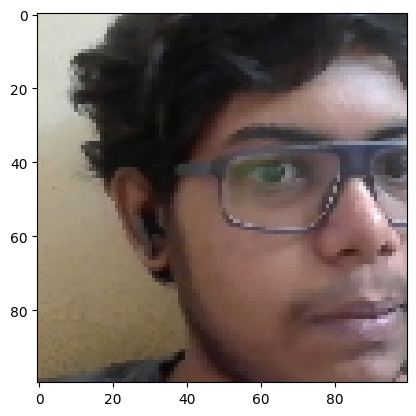

In [137]:
plt.imshow(res[1])

In [138]:
data = data.map(preprocess_twin)
# caching the data so that it can be accessed faster
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [139]:
ex = data.as_numpy_iterator()

In [140]:
ex1 = ex.next()

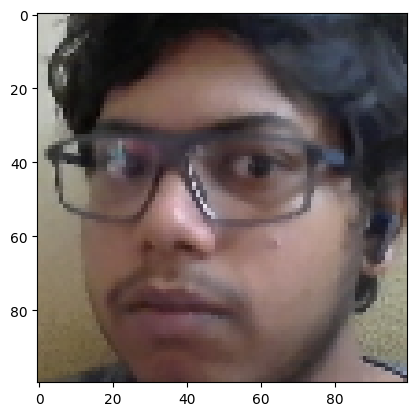

In [141]:
plt.imshow(ex1[0])

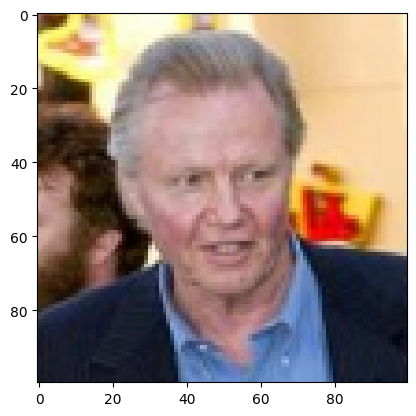

In [142]:
plt.imshow(ex1[1])

In [143]:
ex1[2]

0.0

In [144]:
# training ample
train_data = data.take(round(len(data)*.7))
# batching the data in batches of 16
train_data = train_data.batch(16)
# prefetch minimizes the idle time, as it will have up to 8 additional batches ready to go, minimizing idle time.
train_data = train_data.prefetch(8)

In [145]:
train_samples = train_data.as_numpy_iterator()

In [146]:
train_sample = train_samples.next()

In [147]:
len(train_sample)

3

In [148]:
len(train_sample[0])
print(train_sample[2])

[0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0.]


In [149]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [150]:
inp = Input(shape=(105,105,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [151]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 105, 105, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 96, 96, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 42, 42, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 18, 18, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [152]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [153]:
embedding = make_embedding()

In [154]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [155]:
import tensorflow as tf

class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        # Convert to tensors if inputs are lists
        # (this check is likely redundant if the inputs are always tensors)
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)

        # Ensure tensors have the correct shape (e.g., remove extra dimension)
        input_embedding = tf.squeeze(input_embedding, axis=0)  # Remove leading dimension if necessary
        validation_embedding = tf.squeeze(validation_embedding, axis=0) # Remove leading dimension if necessary

        return tf.math.abs(input_embedding - validation_embedding)

In [156]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
# distances = siamese_layer(inp_embedding, val_embedding)

In [157]:
distances = siamese_layer(inp_embedding, val_embedding)

In [158]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_101>

In [159]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_2 (L1Dist)        │ (None, 4096)           │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [160]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [161]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_3 (L1Dist)        │ (None, 4096)           │              0 │ embedding[2][0],       │
│                           │                        │                │ embedding[3][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [162]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [163]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [164]:
test_batch = train_data.as_numpy_iterator()

In [165]:
batch_1 = test_batch.next()

In [166]:
X = batch_1[:2]
y = batch_1[2]

In [167]:
y

array([1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

In [168]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [169]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [170]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step

 Ep

In [171]:
from tensorflow.keras.metrics import Precision, Recall

In [172]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [173]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


array([[9.9996352e-01],
       [9.9999988e-01],
       [4.1541799e-07],
       [9.9908018e-01],
       [3.3056970e-09],
       [1.0000000e+00],
       [9.9998188e-01],
       [8.0402231e-07],
       [3.4241712e-08],
       [2.0646005e-09],
       [9.9971420e-01],
       [1.0000000e+00],
       [9.9998653e-01],
       [1.0000000e+00],
       [9.9934369e-01],
       [9.0208658e-09]], dtype=float32)

In [174]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]

In [175]:
y_true

array([1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

In [176]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [177]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

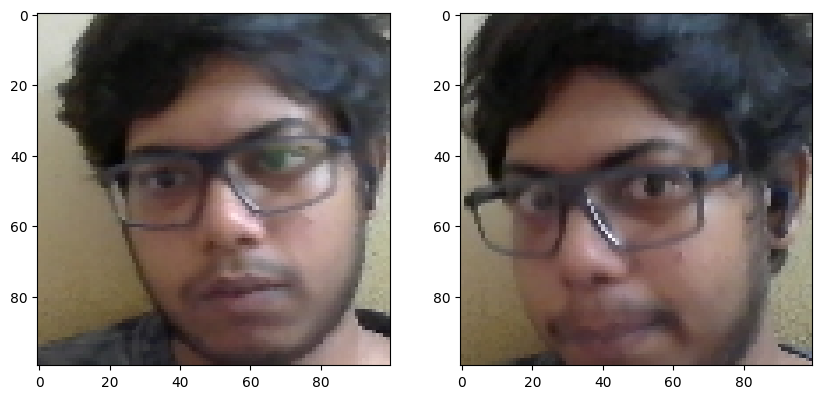

In [178]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

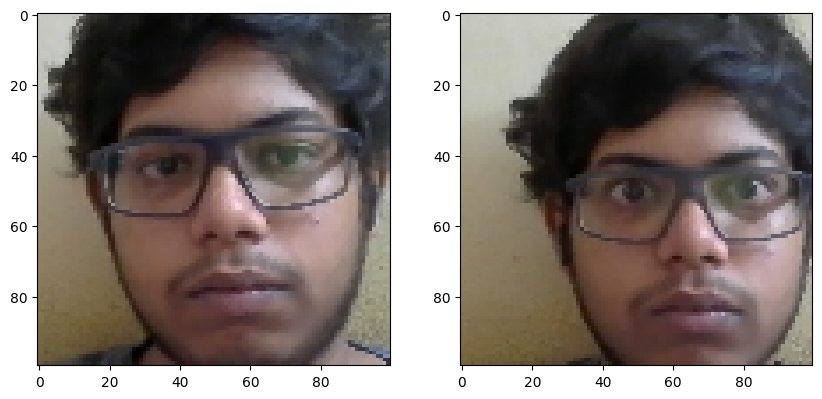

In [179]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

In [180]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [198]:
# prompt: load model from siamesemodel.h5

from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

# Now you can use loaded_model for predictions or further training


In [200]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


array([[9.9996352e-01],
       [9.9999988e-01],
       [4.1541799e-07],
       [9.9908018e-01],
       [3.3056970e-09],
       [1.0000000e+00],
       [9.9998188e-01],
       [8.0402231e-07],
       [3.4241712e-08],
       [2.0646005e-09],
       [9.9971420e-01],
       [1.0000000e+00],
       [9.9998653e-01],
       [1.0000000e+00],
       [9.9934369e-01],
       [9.0208658e-09]], dtype=float32)

In [201]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_3 (L1Dist)        │ (None, 4096)           │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [202]:
# prompt: create a folder 'application_data' and in that folder, create 'input_image' and 'verification_image' folders

import os

# Create the main folder if it doesn't exist
os.makedirs('application_data', exist_ok=True)

# Create the subfolders within 'application_data'
os.makedirs('application_data/input_image', exist_ok=True)
os.makedirs('application_data/verification_images', exist_ok=True)


In [203]:
# prompt: randomly take 50 photos from data/positive folder and copy them to verification_images

import shutil
import random
import os

# Path to the positive images folder
positive_path = os.path.join('data', 'positive')

# Path to the verification images folder
verification_path = os.path.join('application_data', 'verification_images')


positive_dir = os.path.join('data', 'positive')

# Get all files in the directory
image_files = [f for f in os.listdir(positive_dir) if os.path.isfile(os.path.join(positive_dir, f))]

# Randomly select 50 images
selected_images = random.sample(image_files, 50)

# Copy the selected images to the verification images folder
for image_file in selected_images:
  source_path = os.path.join(positive_path, image_file)
  destination_path = os.path.join(verification_path, image_file)
  shutil.copy(source_path, destination_path)


In [204]:
len(os.listdir(os.path.join('application_data', 'verification_images')))

136

In [209]:
import os
import tensorflow as tf

def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        if not image.endswith(('.jpg', '.png', '.jpeg')): # Check file extension to ensure it's an image
            continue

        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [187]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamodel, 0.9, 0.7)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [188]:
# prompt: take photo using webcam

cap = cv2.VideoCapture(0) # Use 0 for default camera
while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow('Webcam Feed', frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):  # Press 'q' to exit
        break

cap.release()
cv2.destroyAllWindows()


***For Google Colab***

In [206]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import os
import cv2
import numpy as np

def take_photo(filename='cropped_photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            // Create a canvas to capture the current frame
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])

    # Specify the folder where you want to save the cropped photo
    save_folder = 'application_data/input_image'  # Change this to your desired folder path
    os.makedirs(save_folder, exist_ok=True)  # Create the folder if it doesn't exist

    # Load the captured image from the binary data
    nparr = np.frombuffer(binary, np.uint8)
    frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Check if the frame is valid before cropping
    if frame is not None and frame.size > 0:
        # Crop the image using the specified dimensions
        frame_cropped = frame[120:120+250, 200:200+250]

        # Save the cropped image
        cropped_filename = os.path.join(save_folder, filename)
        cv2.imwrite(cropped_filename, frame_cropped)

        # Display the cropped image
        from google.colab.patches import cv2_imshow
        cv2_imshow(frame_cropped)

        return cropped_filename
    else:
        print("Error: Captured frame is invalid.")
        return None


<IPython.core.display.Javascript object>

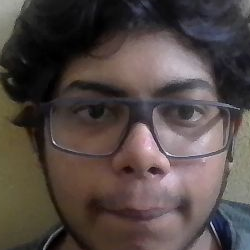

Saved to application_data/input_image/input_image.jpg


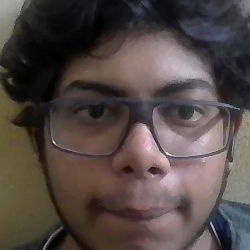

In [211]:
try:
    filename = take_photo('input_image.jpg')  # Specify the desired filename
    print('Saved to {}'.format(filename))

    # Show the image which was just taken.
    display(Image(filename))
except Exception as err:
    print(str(err))

In [212]:
results, verified = verify(model, 0.9, 0.7)
print(verified)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━